### Download the model weights from original Darket's release

# TODO:
1. remove hardcoded filenames from `train_aml.py` and `train.py`
2. cleanup `model_data` folder to reduce size
3. upload `*.weights` to model registry to reduce size for aml/staging

In [41]:
# setting the model variables
import os
import urllib.request

os.makedirs('model_data', exist_ok=True)

yolo3_weights_filename ='model_data/yolov3-tiny.weights' # remove this from model_data after the keras conversion
yolo3_config = 'keras-yolo3/yolov3-tiny.cfg'
model_url = 'https://pjreddie.com/media/files/yolov3-tiny.weights'

FileExistsError: [Errno 17] File exists: 'model_data'

In [4]:
# download the model weights
urllib.request.urlretrieve(model_url, yolo3_weights_filename)

('model_data/yolov3-tiny.weights', <http.client.HTTPMessage at 0x7f66308d1d68>)

## Install dependent packages

In [5]:
!pip uninstall -y azureml-automl-runtime azureml-train-automl-runtime
!pip install -U keras==2.2.4 tensorflow==1.14.0 tensorflow-gpu==1.14.0 pillow matplotlib h5py==2.10.0 tensorboard azureml-sdk==1.13.0 onnxruntime==1.4.0 onnx==1.7.0 azureml-widgets azureml-tensorboard azureml-opendatasets azureml-mlflow azureml-defaults azureml-contrib-services azureml-contrib-interpret

!pip install -U git+git://github.com/microsoft/onnxconverter-common.git@3451bbffe61a2591a17f4d99a405b48e9ae8e395
!pip install -U git+git://github.com/onnx/keras-onnx.git@ff17787c393e2ce34d43185447d7354525f3ba87

Found existing installation: azureml-automl-runtime 1.12.0
Uninstalling azureml-automl-runtime-1.12.0:
  Successfully uninstalled azureml-automl-runtime-1.12.0
Found existing installation: azureml-train-automl-runtime 1.12.0
Uninstalling azureml-train-automl-runtime-1.12.0:
  Successfully uninstalled azureml-train-automl-runtime-1.12.0
     |████████████████████████████████| 312 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 109.2 MB 4.2 kB/s  eta 0:00:01
     |████████████████████████████████| 377.0 MB 10 kB/s s eta 0:00:01
     |████████████████████████████████| 2.2 MB 69.8 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 57.0 MB/s eta 0:00:01
Requirement already up-to-date: h5py==2.10.0 in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (2.10.0)
Requirement already up-to-date: tensorboard in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (2.3.0)
     |████████████████████████████████| 4.4 MB 71.1 MB/s eta 0:00:01
     |██████████████

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### Convert the Darket model to Keras

In [19]:
yolo3_keras_model = 'model_data/tiny_yolo_weights.h5' # Converted from the Darknet weights. Need to pass this as parameter to train.py

# execute the pre-built conversion script provided in the sample
!python3 keras-yolo3/convert.py $yolo3_config $yolo3_weights_filename $yolo3_keras_model

Using TensorFlow backend.
Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.


Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 16)



2020-09-18 01:05:37.051883: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-09-18 01:05:37.058767: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2020-09-18 01:05:37.074914: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-09-18 01:05:37.074979: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (odsc): /proc/driver/nvidia/version does not exist
2020-09-18 01:05:37.077934: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294685000 Hz
2

### Training data
This sample uses the [VOC Pascal dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/#devkit) referred to as _VOCDevkit_.

To generate your own annotation file and class names file.

- One row for one image;  
- Row format: `image_file_path box1 box2 ... boxN`;  
- Box format: `x_min,y_min,x_max,y_max,class_id` (no space).  
- For VOC dataset, try `python voc_annotation.py`  
Here is an example:

        ```
        path/to/img1.jpg 50,100,150,200,0 30,50,200,120,3
        path/to/img2.jpg 120,300,250,600,2
        ...
        ```

In [52]:
# setup the folder for the training dataset

import os

dataset_folder = '/mnt/tmp/'
os.makedirs(dataset_folder, exist_ok=True)

dataset_filename = dataset_folder + 'VOCtrainval2007.tar'
optional_dataset_filename = dataset_folder + 'VOCtest2007.tar'

In [47]:
dataset_url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar'
urllib.request.urlretrieve(dataset_url, dataset_filename)

('/mnt/tmp//VOCtrainval2007.tar', <http.client.HTTPMessage at 0x7f223013cf28>)

In [48]:
optional_dataset_url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar'
urllib.request.urlretrieve(optional_dataset_url, optional_dataset_filename)

('/mnt/tmp//VOCtest2007.tar', <http.client.HTTPMessage at 0x7f223013c908>)

Unpack the dataset and prepare to upload to Datastore in AML.

_This step will take a few minutes._

In [54]:
! tar xf $dataset_filename -C $dataset_folder
! tar xf $optional_dataset_filename -C $dataset_folder

Convert VOC-style dataset to YOLO-style dataset

In [55]:
! python src/voc_annotation.py

In [56]:
%%writefile config.json
{
    "workspace_name": "wopauli_onnx_ws",
    "subscription_id": "a6c2a7cc-d67e-4a1a-b765-983f08c0423a",
    "resource_group": "wopauliseekeredge_rg",
    "location": "westus2"
}

Overwriting config.json


In [57]:
#Initialize Workspace 
from azureml.core import Workspace

## existing AML Workspace in config.json
ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

def_blob_store = ws.get_default_datastore()

wopauli_onnx_ws
wopauliseekeredge_rg
westus2
a6c2a7cc-d67e-4a1a-b765-983f08c0423a


#### OR create a new workspace with the following steps

```
from azureml.core import Workspace

### Change this cell from markdown to code and run this if you need to create a workspace 
### Update the values for your workspace below
ws=Workspace.create(subscription_id="<subscription-id goes here>",
                resource_group="<resource group goes here>",
                name="<name of the AML workspace>",
                location="<location>")
                
ws.write_config()
```

Upload the VOCdevkit to the workspace datastore

In [32]:
def_blob_store.upload(dataset_folder + "/VOCdevkit", target_path="/data/VOCdevkit", show_progress=False)

$AZUREML_DATAREFERENCE_eb993d3b84cf465bb3b4b6ce972b8137

In [8]:
from azureml.data.data_reference import DataReference
from azureml.core import Dataset

training_dataset = Dataset.File.from_files(path=(def_blob_store, '/data/VOCdevkit'))

### Train the Keras model.

In [25]:
import os
import shutil
import glob

#set the project folder
PROJECT_FOLDER = "./aml/staging"
if os.path.exists(PROJECT_FOLDER):
    shutil.rmtree(PROJECT_FOLDER)

os.makedirs(PROJECT_FOLDER, exist_ok=True)

# copy all pythfrom keras-yolo3 repoject folder
files = glob.glob("keras-yolo3/*.py")
for f in files:
    shutil.copy(f, PROJECT_FOLDER)

# copy all config files to the project folder
files = glob.glob("keras-yolo3/*.cfg")
for f in files:
    shutil.copy(f, PROJECT_FOLDER)

# copy all text files to the project folder
files = glob.glob("keras-yolo3/*.txt")
for f in files:
    shutil.copy(f, PROJECT_FOLDER)

# copy all python scripts to project folder
files = glob.glob("src/*.py")
for f in files:
    shutil.copy(f, PROJECT_FOLDER)

In [26]:
! cp -rf keras-yolo3/model_data $PROJECT_FOLDER # copy the dataset under the project folder

! cp -rf keras-yolo3/yolo3 $PROJECT_FOLDER # copy the model files under the project fold er

In [27]:
# copy the Keras model files to PROJECT FOLDER
files = glob.glob("model_data/*.*")
for f in files:
    shutil.copy(f, PROJECT_FOLDER + '/model_data')

Add the optional packages and setup the training environment

In [5]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.runconfig import DEFAULT_GPU_IMAGE

cd = CondaDependencies.create(pip_packages=['keras==2.1.5', 'tensorflow==1.6.0', 'pillow', 'matplotlib', 'h5py', 'tensorboard'], conda_packages=['python=3.6.11'])
myenv = Environment("yolov3")
myenv.python.conda_dependencies = cd
myenv.python.conda_dependencies.add_pip_package("azureml-sdk")
myenv.python.conda_dependencies.add_channel("conda-forge")
myenv.docker.enabled = True
myenv.docker.base_image = DEFAULT_GPU_IMAGE

Setup the training compute

In [9]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for my cluster
CLUSTER_NAME = "gpu-taining"

# Verify that cluster does not exist already
try:
    aml_cluster = AmlCompute(workspace=ws, name=CLUSTER_NAME)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    print("provisioning new compute target")
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="STANDARD_NC6", max_nodes=8, vm_priority="lowpriority"
    )
    aml_cluster = ComputeTarget.create(ws, CLUSTER_NAME, compute_config)

aml_cluster.wait_for_completion(show_output=True)


provisioning new compute target
Creating
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


Define the run config for the experiment

In [10]:
from azureml.core import ScriptRunConfig

src = ScriptRunConfig(
    source_directory=PROJECT_FOLDER,
    script='train_aml.py',
    arguments=["--data", training_dataset.as_named_input('input').as_mount()],
    )

src.run_config.framework = 'python'
src.run_config.target = aml_cluster.name

# Set environment
src.run_config.environment = myenv

Run the training experiment

In [30]:
from azureml.core import Experiment

EXPERIMENT_NAME = "keras-yolo3"

experiment = Experiment(workspace=ws, name=EXPERIMENT_NAME)

run = experiment.submit(config=src)

Submitting /mnt/batch/tasks/shared/LS_root/mounts/clusters/odsc/code/Users/wopauli/odsc/AzureDevOps-onnxruntime-jetson/aml/staging directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


In [31]:
%%time

run.wait_for_completion(show_output=True)

RunId: keras-yolo3_1600396443_f1d26325
Web View: https://ml.azure.com/experiments/keras-yolo3/runs/keras-yolo3_1600396443_f1d26325?wsid=/subscriptions/a6c2a7cc-d67e-4a1a-b765-983f08c0423a/resourcegroups/wopauliseekeredge_rg/workspaces/wopauli_onnx_ws

Streaming azureml-logs/55_azureml-execution-tvmps_109f0e51a5a935d2093fa079b5e7704b4205683eb97bff403ff1fe196ffb33bc_p.txt

2020-09-18T02:34:23Z Starting output-watcher...
2020-09-18T02:34:23Z IsDedicatedCompute == False, starting polling for Low-Pri Preemption
6338ff61ec6234e4a0575abf8fc96a6053c38fd14dd84fb28a96d6ae8054e31c
2020/09/18 02:34:24 setuptask.go:372: Starting App Insight Logger for task:  containerSetup
2020/09/18 02:34:24 logger.go:297: Version: 3.0.01348.0006 Branch: .SourceBranch Commit: f25e3ba
2020/09/18 02:34:24 utils.go:305: /dev/infiniband/uverbs0 found (implying presence of InfiniBand)?: false
2020/09/18 02:34:24 logger.go:297: sshd inside container not required for job, skipping setup.
2020/09/18 02:34:24 appinsightlog

In [33]:
# register the model in the model registry

my_trained_model = 'tiny_yolov3'

from azureml.core import Model
model = Model(ws, my_trained_model)

# download the trainied model
model.download(target_dir='model_data', exist_ok=True)

'model_data/trained_weights_final.h5'

### Convert the model to ONNX and register in the model registry

In [58]:
trained_model_path="model_data/trained_weights_final.h5" # make sure this name matches the downloaded file is the previous step
test_image=dataset_folder + "VOCdevkit/VOC2007/JPEGImages/000001.jpg"
anchors_path="model_data/tiny_yolo_anchors.txt"
classes_path="model_data/voc_classes.txt"
onnx_model_file="model_data/new_yolo.onnx"

!python ./src/convert2onnx.py \
    --model_path $trained_model_path \
    --test_image $test_image \
    --anchors_path $anchors_path \
    --classes_path $classes_path \
    --model_file_name $onnx_model_file \
    --overwrite

Using TensorFlow backend.



2020-09-18 03:10:06.739135: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-09-18 03:10:06.747717: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2020-09-18 03:10:06.773575: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-09-18 03:10:06.773651: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (odsc): /proc/driver/nvidia/version does not exist
2020-09-18 03:10:06.776405: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2294685000 Hz
2020-09-18 03:10:06.777295: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563874b872d0 executing computations on platform Host. Devices:
2020-09-18 03:10:06.777326: I

Test this ONNX Model

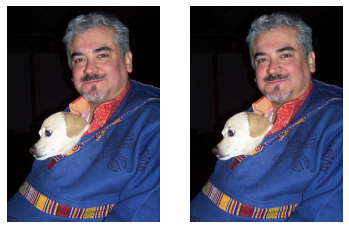

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

image = Image.open(dataset_folder + "VOCdevkit/VOC2007/JPEGImages/000001.jpg")
image_score = Image.open(dataset_folder + "VOCdevkit/VOC2007/JPEGImages/000001_score.jpg")
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(image_score)
ax[0].axis('off')
_ = ax[1].axis('off')

In [62]:
# Register the ONNX model in the workspace registry
from azureml.core.model import Model
Model.register(model_path = onnx_model_file, 
                model_name = "TinyYOLO", 
                workspace = ws,
                description="ONNX model converted from trained Keras/Tf")

Registering model TinyYOLO


Model(workspace=Workspace.create(name='wopauli_onnx_ws', subscription_id='a6c2a7cc-d67e-4a1a-b765-983f08c0423a', resource_group='wopauliseekeredge_rg'), name=TinyYOLO, id=TinyYOLO:4, version=4, tags={}, properties={})

# CLEANUP!!!

Optionally remove all the files downloaded for this exercise.

```
shutil.rmtree(PROJECT_FOLDER)
shutil.rmtree('/tmp/VOCdevkit')

files = glob.glob("aml")
for f in files:
    os.remove(f)
```

## FINISHED. 
Transition to the ADO to review status of the pipeline.